In [19]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
# Scenario folder
folder = '../logs/mushrooms2/scenario_1'
indicators_filename = 'custom_indicators.json'
rewards_history_filename = 'rewards_history.txt'

# Colors for the generative agents architecture and the CoT architecture
SUBCAT_COLORS = [{'facecolor': 'lightblue', 'color': 'blue'},
    {'facecolor': 'lightgreen', 'color': 'green'}
]

In [20]:
def get_results_by_category_and_subcategory(indicators, llm_model, indicator_name, categories, agg_fn):
    """
    Returns a dictionary with the categories as keys and as values a dictionary with the subcategories as keys and a list 
    with the values for each simulation

    Parameters:
    indicators (dict): The indicators dictionary
    llm_model (str): The LLM model
    indicator_name (str): The name of the indicator
    categories (list): The name of the categories
    agg_fn (function): The function to aggregate the values for the agents
    """
    subcategories = list(indicators.keys())

    if indicator_name:
        subcategories_results = {subcat: get_indicator_by_simulation(indicators[subcat][llm_model], indicator_name) for subcat in subcategories}
    else:
        subcategories_results = {subcat: indicators[subcat][llm_model] for subcat in subcategories}
    
    # If there are no categories, return the results by subcategory
    if not categories:
        results = {}
        for subcat in subcategories:
            results[subcat] = agg_fn(subcategories_results[subcat], None)
        return results

    results_by_cat = {}
    for cat in categories:
        results_by_cat[cat] = {}
        for subcat in subcategories:
            results_by_cat[cat][subcat] = agg_fn(subcategories_results[subcat], cat)
    return results_by_cat

In [21]:
def create_box_plot(results, subcat_colors, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    try:
        subcategories = list(results[categories[0]].keys())

    except:
        # If there are is an exception is because the data has no categories
        subcategories = categories
        categories = None
        

    if norm_across_cats and categories is not None:
        results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations
        # Mask to avoid division by zero
        mask = results.sum(axis=0, keepdims=True) == 0
        results = results/(results.sum(axis=0, keepdims=True)+mask)

    if categories is None:
        positions = np.arange(len(subcategories))+1
    else:
        positions = np.arange(len(categories)*len(subcategories))+1
    if kwargs['scale_xticks']:
        positions = positions*kwargs['scale_xticks']
    if kwargs['xticks_translation']:
        positions += kwargs['xticks_translation']

    fig, ax = plt.subplots(**kwargs.get('subplots_kwargs',{}))
    for s, subcategory in enumerate(subcategories):
        boxprops = subcat_colors[s].copy()
        if categories is not None:
            if norm_across_cats:
                data = [results[c][s] for c in range(len(categories))]
            else:
                data = [results[c][subcategory] for c in categories]
        else:
            # data = results[s]
            data = results[subcategory]
        
        ax.boxplot(data, positions=positions[s::len(subcategories)], patch_artist=True, boxprops=boxprops, showmeans=True)

    if categories is not None:
        plt.xticks(positions[::len(subcategories)], kwargs['xticks_names'] if kwargs['xticks_names'] else categories)
    else:
        plt.xticks(positions, kwargs['xticks_names'] if kwargs['xticks_names'] else subcategories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])

    if categories is not None:
        legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                                label=subcategory) for i, subcategory in enumerate(subcategories)]
        plt.legend(handles=legend_elements, loc='upper right')

    return ax


def create_line_plot(results, subcat_colors, agg=np.mean, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    agg (function): The function to aggregate the results. There should be a single value per category-subcategory
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    subcategories = list(results[categories[0]].keys())
    # results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations

    # if norm_across_cats and categories is not None:
    #     # Mask to avoid division by zero
    #     mask = results.sum(axis=0, keepdims=True) == 0
    #     results = results/(results.sum(axis=0, keepdims=True)+mask)

    positions = np.arange(len(categories))

    for s, subcategory in enumerate(subcategories):
        data = [agg(results[c][subcategory]) for c in categories]
        plt.plot(data, label=subcategory, color=subcat_colors[s]['color'])

    plt.xticks(positions, categories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])

    legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                            label=subcategory) for i, subcategory in enumerate(subcategories)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

In [22]:
def take_juan_result(actions_indicator_by_sim, category):
        # If there is no category, return the results for Juan
        if category is None:
                return [sim['Juan'] if 'Juan' in sim else 0 for sim in actions_indicator_by_sim]

        return [sim['Juan'][category] if category in sim['Juan'] else 0 for sim in actions_indicator_by_sim]

In [23]:
def bots_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if agent != 'Juan'] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if agent != 'Juan'] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

# Reward analysis

In [24]:
def get_metrics_of_simulation(filename):
    rewards = {}
    exec_time = 0
    total_cost = 0
    with open(filename, 'r') as f:
        reward_patt = r'.*end_game:\d+ - Player (\w+): score is (\d+(\.\d+)?)'
        time_patt = r'.* - Execution time: (\d+(\.\d+)?)'
        cost_patt = r'.*- LLM total cost: (\d+(\.\d+)?)'
        for line in f:
            m_reward = re.search(reward_patt, line)
            m_time = re.search(time_patt, line)
            m_cost = re.search(cost_patt, line)
            if m_reward:
                rewards[m_reward.group(1)] = float(m_reward.group(2))
            elif m_cost:
                total_cost = float(m_cost.group(1))
            elif m_time:
                exec_time = float(m_time.group(1))
    return rewards, exec_time, total_cost

In [25]:
rewards = {}
costs = {}
exec_times = {}
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    llm_models = os.listdir(model_path)

    rewards[model] = {}
    costs[model] = {}
    exec_times[model] = {}

    # Iterate over the LLMs per agent architecture
    for llm_model in llm_models:
        # Get the list of simulations per LLM and agent architecture
        llm_model_path = os.path.join(model_path, llm_model)

        rewards[model][llm_model] = []
        costs[model][llm_model] = []
        exec_times[model][llm_model] = []

        # Iterate over the simulations
        for sim_folder in os.listdir(llm_model_path):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(llm_model_path, sim_folder)):
                continue

            patt = r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}'
            folder_time = re.search(patt, sim_folder)
            rewards_filename = folder_time.group() + '.log'

            # Load the rewards of the simulation
            rewards_file = os.path.join(llm_model_path, sim_folder, rewards_filename)
            sim_rewards, sim_time, sim_cost = get_metrics_of_simulation(rewards_file)
            rewards[model][llm_model].append(sim_rewards)
            costs[model][llm_model].append(sim_cost)
            exec_times[model][llm_model].append(sim_time)

Total costs

In [26]:
costs_results = {}
for arch in costs:
    costs_results[arch] = {}
    for llm in costs[arch]:
        costs_results[arch][llm] = {'mean': np.mean(costs[arch][llm]), 'std': np.std(costs[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(costs_results)
df

,generative_agents,cot_agent
llama31_8b,"{'mean': 0.132, 'std': 0.06289674077406554}",NaN
llama31_70b,"{'mean': 0.748, 'std': 0.3776453362614187}",NaN
gpt4o_mini,"{'mean': 0.293, 'std': 0.1129645962237727}","{'mean': 0.012, 'std': 0.005999999999999999}"
gpt4o,"{'mean': 10.193999999999999, 'std': 6.13014551...","{'mean': 0.279, 'std': 0.10709341716464182}"


Total execution time

In [27]:
time_results = {}
for arch in exec_times:
    time_results[arch] = {}
    for llm in exec_times[arch]:
        time_results[arch][llm] = {'mean': np.mean(exec_times[arch][llm]), 'std': np.std(exec_times[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(time_results)
df

,generative_agents,cot_agent
llama31_8b,"{'mean': 37.751, 'std': 17.233102709610943}",NaN
llama31_70b,"{'mean': 60.029999999999994, 'std': 26.7435704...",NaN
gpt4o_mini,"{'mean': 67.264, 'std': 39.52380781250714}","{'mean': 6.189, 'std': 2.1486854120601278}"
gpt4o,"{'mean': 115.04699999999998, 'std': 60.4035798...","{'mean': 4.8660000000000005, 'std': 1.74600229..."


Total rewards

In [28]:
rewards

{'generative_agents': {'llama31_8b': [{'Juan': 1.8,
    'bot_1': 5.8,
    'bot_2': 4.8,
    'bot_3': 2.8,
    'bot_4': 4.8},
   {'Juan': 10.15,
    'bot_1': 20.9,
    'bot_2': 23.15,
    'bot_3': 18.9,
    'bot_4': 16.9},
   {'Juan': 11.65,
    'bot_1': 24.65,
    'bot_2': 32.9,
    'bot_3': 22.9,
    'bot_4': 29.9},
   {'Juan': 4.2,
    'bot_1': 16.95,
    'bot_2': 17.95,
    'bot_3': 14.95,
    'bot_4': 21.95},
   {'Juan': 9.1, 'bot_1': 20.1, 'bot_2': 25.1, 'bot_3': 21.35, 'bot_4': 16.35},
   {'Juan': 17.3,
    'bot_1': 61.05,
    'bot_2': 58.8,
    'bot_3': 69.8,
    'bot_4': 62.05},
   {'Juan': 2.95, 'bot_1': 7.45, 'bot_2': 11.45, 'bot_3': 5.7, 'bot_4': 13.45},
   {'Juan': 10.2,
    'bot_1': 17.95,
    'bot_2': 23.95,
    'bot_3': 17.95,
    'bot_4': 19.95},
   {'Juan': 8.35,
    'bot_1': 34.35,
    'bot_2': 24.35,
    'bot_3': 29.35,
    'bot_4': 24.6},
   {'Juan': 2.6, 'bot_1': 6.35, 'bot_2': 4.35, 'bot_3': 2.35, 'bot_4': 10.35}],
  'llama31_70b': [{'Juan': 6.15,
    'bot_1': 13.

In [29]:
rewards_results = {}
for arch in rewards:
    rewards_results[arch] = {}
    for llm in rewards[arch]:
        data = list(map(lambda x: x['Juan'], rewards[arch][llm]))
        rewards_results[arch][llm] = {'mean': np.mean(data), 'std': np.std(data)}

# Make a table with the costs
df = pd.DataFrame(rewards_results)
df

,generative_agents,cot_agent
llama31_8b,"{'mean': 7.829999999999998, 'std': 4.667558248...",NaN
llama31_70b,"{'mean': 21.015000000000004, 'std': 9.75628131...",NaN
gpt4o_mini,"{'mean': 17.675, 'std': 7.404297738475945}","{'mean': 14.955000000000002, 'std': 6.33227644..."
gpt4o,"{'mean': 17.155, 'std': 9.904858656235334}","{'mean': 11.83, 'std': 6.414990257202267}"


In [30]:
llms = ['gpt4o', 'gpt4o_mini', 'llama31_70b', 'llama31_8b']
rewards_results = {}
for llm in llms:
    rewards_results[llm] = []
    r = take_juan_result(rewards['generative_agents'][llm], None)
    rewards_results[llm].append(r)
rewards_results

{'gpt4o': [[7.2, 6.2, 21.1, 24.85, 31.55, 2.6, 12.75, 25.75, 10.8, 28.75]],
 'gpt4o_mini': [[14.4,
   22.55,
   24.2,
   18.35,
   16.25,
   32.3,
   10.3,
   21.05,
   12.35,
   5.0]],
 'llama31_70b': [[6.15,
   19.3,
   12.75,
   25.35,
   12.75,
   18.9,
   15.2,
   33.2,
   39.8,
   26.75]],
 'llama31_8b': [[1.8, 10.15, 11.65, 4.2, 9.1, 17.3, 2.95, 10.2, 8.35, 2.6]]}

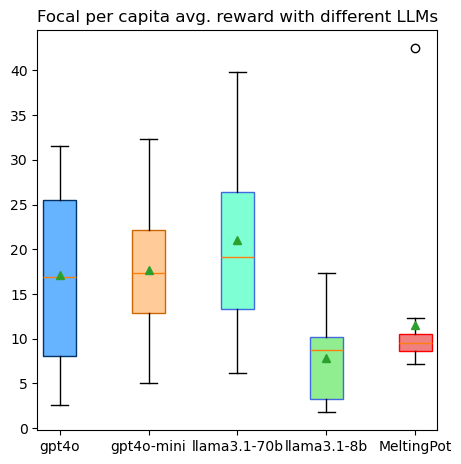

In [31]:
# rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, take_juan_result)
rewards_results['Meltingpot'] = [
    9.515864759,
    9.772210377,
    9.853513703,
    8.705473098,
    8.989089184,
    7.784704519,
    42.44193548,
    10.36856801,
    9.565817449,
    8.978874068,
    8.389238845,
    7.167383513,
    7.480203237,
    12.31393855,
    11.18722784,
    11.66918489
]

subcat_colors = [
    {"facecolor": "#66b3ff", "color": "#003366"},   # GPT4o (CoTAgents y GenAgents)
    {"facecolor": "#ffcc99", "color": "#cc6600"},  # GPT4o-mini (CoTAgents y GenAgents)
    {'facecolor': 'aquamarine', 'color': 'royalblue'}, # Llama 70b
    {'facecolor': 'lightgreen', 'color': 'royalblue'}, # Llama 8b
    {'facecolor': 'lightcoral', 'color': 'red'}, # MeltingPot
]
title = 'Focal per capita avg. reward with different LLMs'
ax = create_box_plot(rewards_results, subcat_colors, title=title, scale_xticks=0.4, 
                     xticks_translation=-0.3, subplots_kwargs={'figsize':(5,5)},
                     xticks_names=['gpt4o', 'gpt4o-mini', 'llama3.1-70b', 'llama3.1-8b', 'MeltingPot']
                     )
# ax.margins(0)
ax.set_xlim(0, 1.8)
plt.subplots_adjust(left=0, right=0.8, top=0.9, bottom=0.1)
plt.show()

In [18]:
rewards_results

{'gpt4o_mini': [[14.4,
   22.55,
   24.2,
   18.35,
   16.25,
   32.3,
   10.3,
   21.05,
   12.35,
   5.0]],
 'llama31_70b': [[6.15,
   19.3,
   12.75,
   25.35,
   12.75,
   18.9,
   15.2,
   33.2,
   39.8,
   26.75]],
 'llama31_8b': [[1.8, 10.15, 11.65, 4.2, 9.1, 17.3, 2.95, 10.2, 8.35, 2.6]],
 'Meltingpot': [9.515864759,
  9.772210377,
  9.853513703,
  8.705473098,
  8.989089184,
  7.784704519,
  42.44193548,
  10.36856801,
  9.565817449,
  8.978874068,
  8.389238845,
  7.167383513,
  7.480203237,
  12.31393855,
  11.18722784,
  11.66918489]}